In [17]:
import numpy as np
# import scipy.stats as ss
# from scipy.spatial import distance_matrix
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import SpectralClustering
from sklearn.metrics.cluster import adjusted_rand_score
from tqdm.notebook import tqdm
from collections import defaultdict
from multiprocessing import Pool

In [2]:
INPUT_PATH="/mnt/geofflab/SNP_barcoding/Lvar_annotations_v3_Jan2021/transcripts.csv"
COUNTS_PATH="/mnt/geofflab/SNP_barcoding/LV_counts_10hpf.csv"

In [3]:
heterozygosity = 0.02 # This is the rate of SNPs per base
alphabet = {"A":0, "C":1, "G":2, "T":3}

# genotypes where chromosome order matters (used internally during generation)
genotypes_internal = {
    "AA":0, "AC":1, "AG":2, "AT":3, 
    "CA":4, "CC":5, "CG":6, "CT":7,
    "GA":8, "GC":9, "GG":10, "GT":11, 
    "TA":12, "TC":13, "TG":14, "TT":15,
}

# genotypes where chromosome order doesn't matter (what we see)
genotypes_external = {
"AA":0, "AC":1, "AG":2, "AT":3, 
"CA":1, "CC":4, "CG":5, "CT":6,
"GA":2, "GC":4, "GG":7, "GT":8, 
"TA":3, "TC":6, "TG":8, "TT":9,
}

In [4]:
class EmbryoSequenceSimulator:
    def __init__(self, input_df, n_embryos):
        
        # pd data frame
        self.input_df = input_df # cols: gene,chromosome,start,end,direction,sequence
        self.n_embryos = n_embryos
        
        # Number of cells that can be harvested from embryo
        self.avg_harvested_cells = 20
        self.sd_harvested_cells = 3
        self.alphabet = {"A":0, "C":1, "G":2, "T":3}
        
        # Global parental chromatid maps
        self.m0_chromatid = None
        self.m1_chromatid = None
        self.p0_chromatid = None
        self.p1_chromatid = None
        
    def global_seeding(self, heterozygosity):
        """
        Uniform seeding of SNP locations for each gene with frequency according to heterozygosity.
        Parental chromatid seeding (2 chromatids from mother, 2 chromatids from father)
        """
        
        # All the SNPs present in the parents
        snp_map_overall = None
        
        # Setting parental chromatid maps
        for parent in ["m0","m1","p0","p1"]:
            
            # Create a profile of SNPs for each parent chromosome
            snp_map = defaultdict(dict)
            sequence_map = defaultdict(dict)
            
            for idx,transcript_entry in self.input_df.iterrows():
                gene,chrom,start,end,direction,sequence = transcript_entry
                N = len(sequence)
                num_snps = round(N*heterozygosity)
                snp_positions = list(np.sort(random.sample(range(N),num_snps)))
                snp_map[chrom][gene] = snp_positions
                sequence_map[chrom][gene] = sequence
                
            # Add the snp map we just made to the global collection of SNPs
            if snp_map_overall is None:
                snp_map_overall = snp_map
            else:
                for idx,transcript_entry in self.input_df.iterrows():
                    gene,chrom,start,end,direction,sequence = transcript_entry
                    snp_map_overall[chrom][gene].extend(snp_map[chrom][gene])
            
            chromatid = defaultdict(dict)
            # If we have a SNP, this is the probability of going reference to 
            transition_probs = np.array([[0, 1/3, 1/3, 1/3],
                                         [1/3, 0, 1/3, 1/3],
                                         [1/3, 1/3, 0, 1/3],
                                         [1/3, 1/3, 1/3, 0]])
            
            for chrom,genes in snp_map.items():            
                for gene,snp_positions in genes.items():
                    sequence_list = [char for char in sequence_map[chrom][gene]]
                    snp_profile = {locus:np.random.choice(list(self.alphabet.keys()), 
                                                          p=transition_probs[alphabet[sequence_list[locus]]]) for locus in snp_positions}
                    
                    for locus,char in snp_profile.items():
                        sequence_list[locus] = char
                    
                    chromatid[chrom][gene] = "".join(sequence_list)
                
            # Assign seeded parental chromatid to its class field (global over all embryos)
            if parent == "m0":
                self.m0_chromatid = chromatid
            elif parent == "m1":
                self.m1_chromatid = chromatid
            elif parent == "p0":
                self.p0_chromatid = chromatid
            elif parent == "p1":
                self.p1_chromatid = chromatid
                
        return snp_map_overall
    
    def embryo_population_simulation(self, count_df=None):
        """
        Simulating SNP profile for each embryo across all transcript entries in input_df.
        For this simulator, not explicitly generating scRNA-seq reads for each embryo (reduces space)
        """

        # map: idx of transcript entry -> list of snp positions
        snp_map = self.global_seeding(heterozygosity)
        true_clusters = []
        cluster_label = 0
        
        population_profile = []
        for embryo in range(self.n_embryos):
            
            # each entry a list of genotypes for an embryo across all transcripts
            snp_profile,gene_locus_map = self.determine_embryo_genotype(snp_map)

            # Harvest some number of cells, which will theoretically have identical SNP profiles
            n_harvested_cells = round(np.random.normal(self.avg_harvested_cells,self.sd_harvested_cells))
            for __ in tqdm(range(n_harvested_cells), desc=f"Simulating embryo {embryo}"):
                
                if count_df is not None:
                    snp_profile_dropout = self.sample_dropout_profile(
                        snps=snp_profile.copy(),
                        loci_map=gene_locus_map,
                        count_df=count_df
                    )
                    population_profile.append(snp_profile_dropout)
                    true_clusters.append(cluster_label)
                else:
                    population_profile.append(snp_profile)
                    true_clusters.append(cluster_label)
                    
            cluster_label += 1
                
        return np.array(population_profile),true_clusters, gene_locus_map
    
    def sample_dropout_profile(self, snps, loci_map, count_df):
        """
        Sample a dropout profile from single-cell transcript read count df, and 
        introduce dropout over the snp_profile according to the dropout profile.
        """
        # Sample a cell's counts
        sampled_dprofile = random.choice(count_df.columns.tolist()[2:])
        
        for idx,row in count_df[["Lv_name",sampled_dprofile]].iterrows():
            gene,count = row
            
            # If we have no counts, then we have can't detect the genotype
            if count <= 1:
                for locus in loci_map[gene]:
                    snps[locus] = -1 # -1 genotype -> undetected
            else:
                # Otherwise compute the probability of only seeing one of the chromosomes, or both
                prob_one = 0.5**count
                prob_both = 1 - 2*prob_one
                
                # Now choose whether we only see the first chromosome, second chromosome, or both
                seen = np.random.choice([0, 1, 2], p=[prob_one, prob_one, prob_both])
                
                if seen == 0:
                    # Convert internal to external genotypes on the first chromosome
                    first_mapping = {0:0, 1:0, 2:0, 3:0,
                                     4:4, 5:4, 6:4, 7:4,
                                     8:7, 9:7, 10:7, 11:7,
                                     12:9, 13:9, 14:9, 15:9}
                    
                    # Convert the SNP read to it's value on one of the chromosomes
                    for snp_loc in loci_map[gene]:
                        snps[snp_loc] = first_mapping[snps[snp_loc]]
                        
                elif seen == 1:
                    # Convert internal to external genotypes on the first chromosome
                    second_mapping = {0:0, 1:4, 2:7, 3:9,
                                     4:0, 5:4, 6:7, 7:9,
                                     8:0, 9:4, 10:7, 11:9,
                                     12:0, 13:4, 14:7, 15:9}
                    
                    # Convert the SNP read to it's value on one of the chromosomes
                    for snp_loc in loci_map[gene]:
                        snps[snp_loc] = second_mapping[snps[snp_loc]]
                        
                else:

                    # Convert internal to external genotypes on both chromosomes
                    both_mapping = {0:0, 1:1, 2:2, 3:3,
                                     4:1, 5:4, 6:5, 7:6,
                                     8:2, 9:4, 10:7, 11:8,
                                     12:3, 13:6, 14:8, 15:9}
                    
                    # Convert the SNP read to it's value on one of the chromosomes
                    for snp_loc in loci_map[gene]:
                        snps[snp_loc] = both_mapping[snps[snp_loc]]
        
        return snps
        
    
    def determine_embryo_genotype(self, snp_map):
        """
        Simulate array containing genotypes over all transcripts 
        (concatenated into single list)
        """
                
        # state (genotype) across all transcripts
        snp_genotypes,idx = [],0
        gene_locus_map = defaultdict(list)
                
        # map: idx of transcript entry -> sequence after homologous recombination
        m_chromatid,p_chromatid = self.simulate_embryo_sequence()
        for chrom,genes in snp_map.items():
            for gene,snp_positions in genes.items():                
                m_sequence = m_chromatid[chrom][gene]
                p_sequence = p_chromatid[chrom][gene]
                for locus in snp_positions:
                    snp_genotype = "".join([m_sequence[locus],p_sequence[locus]])
                    snp_genotypes.append(genotypes_internal[snp_genotype])
                    gene_locus_map[gene].append(idx)
                    idx += 1
                
        return snp_genotypes,gene_locus_map
                
    def simulate_embryo_sequence(self):
        """
        Given seeded parental chromatids and a map of SNP locations for each transcript,
        simulate embryo sequences
        """
        
        updated_m0,updated_m1 = defaultdict(dict),defaultdict(dict)
        updated_p0,updated_p1 = defaultdict(dict),defaultdict(dict)
        
        for parent in ["mother","father"]:
            
            # Consider homologous recombination with respect to each chromosome
            for chr_num in np.sort(np.unique(df["chromosome"])):
                
                # Subset df for specific chr, sorted by start position 
                chr_df = self.input_df[self.input_df["chromosome"] == chr_num].sort_values(by=["start"])
                
                # Chiasma point chosen over range of transcripts reads
                transcript_range = range(chr_df["start"].iloc[0], chr_df["start"].iloc[-1]+len(chr_df["sequence"].iloc[-1])) 
                chiasma = random.choice(transcript_range)
                chiasma_flag = 1 # 1 means chiasma has not been reached; 0 means passed chiasma
                for idx,transcript_entry in chr_df.iterrows():
                    if parent == "mother":
                        chiasma_flag = self.homologous_recombination(
                            transcript_entry = transcript_entry,
                            updated_c0 = updated_m0,
                            updated_c1 = updated_m1,
                            c0 = self.m0_chromatid,
                            c1 = self.m1_chromatid,
                            chiasma = chiasma,
                            flag = chiasma_flag
                        )
                    else:
                        chiasma_flag = self.homologous_recombination(
                            transcript_entry = transcript_entry,
                            updated_c0 = updated_p0,
                            updated_c1 = updated_p1,
                            c0 = self.p0_chromatid,
                            c1 = self.p1_chromatid,
                            chiasma = chiasma,
                            flag = chiasma_flag
                        )

        m_chromatid = self.chromosome_inheritance(updated_m0, updated_m1)
        p_chromatid = self.chromosome_inheritance(updated_p0, updated_p1)
        
        return m_chromatid,p_chromatid
    
    def homologous_recombination(self,transcript_entry,updated_c0,updated_c1,c0,c1,chiasma,flag):
        """
        for a given transcript entry, simulate process of homologous recombination, given
        a uniformly selected chiasma point. 
        """
        
        gene,chrom,start,end,direction,sequence = transcript_entry
        
        # 1 means chiasma has not been reached; 0 means passed chiasma
        if flag <= start and flag == 1:
            flag = 0
            
            # Case where chiasma point lies within a gene
            if chiasma in range(start,start+len(sequence)):
                updated_c0[chrom][gene] = c0[chrom][gene][:chiasma]+c1[chrom][gene][chiasma:]
                updated_c1[chrom][gene] = c1[chrom][gene][:chiasma]+c0[chrom][gene][chiasma:]
                return flag

        if flag == 1: # Before chiasma point has been reached
            updated_c0[chrom][gene] = c0[chrom][gene]
            updated_c1[chrom][gene] = c1[chrom][gene]
        else: # After chiasma point has been reached
            updated_c0[chrom][gene] = c1[chrom][gene]
            updated_c1[chrom][gene] = c0[chrom][gene]
        
        return flag
    
    def chromosome_inheritance(self,c0,c1):
        """
        Given homologous chromosomes, randomly select one to be inherited by embryo
        """
        
        chromatid = defaultdict(dict)
        for chrom in c0:
            chromatid[chrom] = c0[chrom] if random.random() <= 0.5 else c1[chrom]
        
        return chromatid
                  
    

In [10]:
n_embryos = 10
df = pd.read_csv(INPUT_PATH)
df = df.dropna()

count_df = pd.read_csv(COUNTS_PATH)
count_df = count_df[count_df["Lv_name"] != "LVA_m28240.t1"]

In [11]:
# Dowsample all sequences to max 150 bp
for ind in tqdm(df.index):
    start = df.loc[ind, 'start']
    end = df.loc[ind, 'end']
    sequence = df.loc[ind, 'sequence']
    
    # If a sequence is longer than 150, trim it
    if np.absolute(end-start) > 150:
        df.loc[ind, 'end'] = start + 150
        df.loc[ind, 'sequence'] = sequence[:150]

100%|██████████| 29836/29836 [00:53<00:00, 559.27it/s]


In [12]:
simulator = EmbryoSequenceSimulator(df, n_embryos)
X,true_clusters,gene_locus_map = simulator.embryo_population_simulation(count_df)
print(X.shape)
print(X)

Simulating embryo 9: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]


(191, 358032)
[[-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [21]:
def adjustedHamming(g0, g1):
# Computes a hamming distance normalized by where we have
# data. ie. entries are not -1.
    if len(g0) != len(g1):
        raise ValueError("Sequence lengths unequal.")
    else:
        hd,adjlen = 0, 0
        for i, j in zip(g0, g1):
            if i == -1 or j == -1: 
                continue
            
            adjlen += 1
            
            if i != j: 
                hd += 1
                
        if adjlen == 0:
            return np.inf
        else:
            return hd/adjlen

def compute_row_ham_dists(i):
# Compute a row of hamming dists
    row_hd = np.zeros(n-i)
    
    for j in range(i, n):
        hd = adjustedHamming(X[i,:], X[j,:])
        row_hd[j-i] = hd
        
    return row_hd

NUM_PROC = 80

with Pool(NUM_PROC) as p:
    ham_dists = list(tqdm(p.imap(compute_row_ham_dists, range(n)), total=n))

hd = np.zeros((n, n))

for i in range(n):
    hd[i, i:] = ham_dists[i]

hd = hd + hd.T

  0%|          | 0/191 [00:00<?, ?it/s]

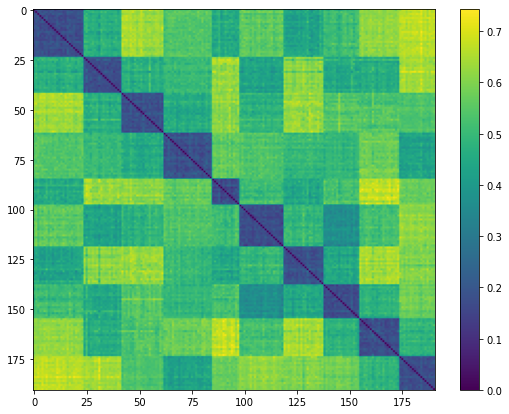

In [22]:
fig,ax = plt.subplots(figsize=(9,7))
h1 = ax.imshow(ddistX, aspect='auto')
fig.colorbar(h1, ax=ax)
plt.show()

In [14]:
clusters = SpectralClustering(n_clusters=n_embryos,assign_labels="discretize").fit(ddistX)
print(clusters.labels_)

/mnt/geofflab/jupyterhub/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_spectral.py:484: UserWarning: The spectral clustering API has changed. ``fit``now constructs an affinity matrix from data. To use a custom affinity matrix, set ``affinity=precomputed``.
  warnings.warn("The spectral clustering API has changed. ``fit``"


[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 5 5 5 5 5 5 5 5 5 5 5 5 5 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3]


In [15]:
print(adjusted_rand_score(true_clusters,clusters.labels_))

1.0
